# 금융 데이터로 살펴본 Base 모델

## 개요

### 시스템 구성

```
사용자 질문 입력 → LLM API 호출 → SQL 생성 → DB 실행 → 결과 응답
```

### 본 문서 구현 내용

| 항목 | 설명 |
|-----|------|
| DB 스키마 | 4개 테이블 (PoC용 캐글 데이터) |
| 프롬프트 | SQL 전문가 페르소나 + 전체 스키마 주입 |
| LLM | GPT-4.1-mini |
| 워크플로우 | 단일 LLM 호출 → SQL 실행 → 응답 |

## 코드 구현

In [1]:
from langchain.chat_models import init_chat_model
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.messages import (
    AnyMessage,
    HumanMessage,
    ToolMessage,
    SystemMessage,
    AIMessage,
)

from langgraph.graph import StateGraph, END, START, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import InMemorySaver

from sqlalchemy import create_engine
from IPython.display import display, Image
from typing import Literal

import pandas as pd

### Initialize Database

In [2]:
def setup_database(db_path: str = "sqlite:///data/mydb.db") -> SQLDatabase:
    """Initialize SQL database connection."""
    engine = create_engine(db_path)
    db = SQLDatabase(engine)
    return db

# Global instances
db = setup_database()

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")

Dialect: sqlite
Available tables: ['cards', 'customers', 'merchant_category', 'transactions']


### Initialize Model

In [4]:
def setup_llm(model: str = "gpt-4.1-mini", temperature: float = 0):
    """Initialize LLM for the agent."""
    llm = init_chat_model(
        model=model, model_provider="openai", temperature=temperature
    )
    return llm

# Global instances
llm = setup_llm()

### Nodes & Tools

In [ ]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

run_query_tool = next(tool for tool in tools if tool.name=="sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query_tool")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [6]:
def inject_db_info(state: MessagesState):
    all_tables = db.get_usable_table_names()
    schema_info = db.get_table_info()  # 전체 스키마

    db_context = f"""<database_info>
<tables>{", ".join(all_tables)}</tables>
<schema>
{schema_info}
</schema>
</database_info>"""

    return {"messages": [AIMessage(content=db_context)]}


def generate_query(state: MessagesState):

    generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
        dialect=db.dialect,
        top_k=5,
    )

    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}

### Build LangGraph

In [7]:
def should_continue(state: MessagesState) -> Literal[END, "run_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "run_query"


def create_sql_agent_graph():
    """
    Create the LangGraph workflow for SQL agent.
    
    Workflow:
        START → generate_sql → execute_query → generate_answer → END

    기획한 아키텍처:
        사용자 질문 입력 -> SQL 생성 -> DB SQL 실행 -> 결과물 사용자에게 응답.
    """

    # Create graph
    builder = StateGraph(MessagesState)

    # Add nodes
    builder.add_node("inject_db_info", inject_db_info)
    builder.add_node("generate_query", generate_query)
    builder.add_node("run_query", run_query_node)

    # Add Edges
    builder.add_edge(START, "inject_db_info")
    builder.add_edge("inject_db_info", "generate_query")
    builder.add_conditional_edges(
        "generate_query",
        should_continue,
    )
    builder.add_edge("run_query", "generate_query")
    builder.add_edge("generate_query", END)

    # Compile
    checkpointer = InMemorySaver() 
    agent = builder.compile(checkpointer=checkpointer)

    return agent

In [8]:
agent = create_sql_agent_graph()

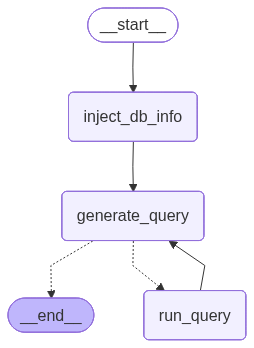

In [9]:
display(Image(agent.get_graph().draw_mermaid_png()))

### Test

In [10]:
config = {"configurable": {"thread_id": "1"}}
question = "transactions 테이블에 레코드가 몇 개 있나요?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    config,
    stream_mode="values",
):
    if "messages" in step:
        step["messages"][-1].pretty_print()

================================ Human Message =================================

transactions 테이블에 레코드가 몇 개 있나요?
================================== Ai Message ==================================

<database_info>
<tables>cards, customers, merchant_category, transactions</tables>
<schema>

CREATE TABLE cards (
	account_id BIGINT, 
	customer_id BIGINT, 
	card_brand TEXT, 
	card_type TEXT, 
	card_number BIGINT, 
	expires TEXT, 
	cvv BIGINT, 
	has_chip TEXT, 
	num_cards_issued BIGINT, 
	credit_limit_usd FLOAT, 
	acct_open_date TEXT, 
	year_pin_last_changed BIGINT, 
	card_on_dark_web TEXT
)

/*
3 rows from cards table:
account_id	customer_id	card_brand	card_type	card_number	expires	cvv	has_chip	num_cards_issued	credit_limit_usd	acct_open_date	year_pin_last_changed	card_on_dark_web
4524	825	Visa	Debit	4344676511950444	2022-12-01	623	YES	2	24295.0	2002-09-01	2008	No
2731	825	Visa	Debit	4956965974959986	2020-12-01	393	YES	2	21968.0	2014-04-01	2014	No
3701	825	Visa	Debit	4582313478255491	2024-02

## 결과 확인

In [11]:
def check_question(question, thread_id="123"):
    generated_sql = None  # SQL 저장용

    for step in agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        {"configurable": {"thread_id": thread_id}},
        stream_mode="values",
    ):
        if "messages" not in step:
            continue

        msg = step["messages"][-1]

        if isinstance(msg, HumanMessage):
            print(f"📝 [USER QUERY]\n{msg.content}\n")

        elif isinstance(msg, AIMessage) and msg.tool_calls:
            for tc in msg.tool_calls:
                if tc["name"] == "sql_db_query":
                    generated_sql = tc['args']['query']
                    print(f"🔧 [GENERATED SQL]\n{generated_sql}\n")

        elif isinstance(msg, ToolMessage):
            if "error" in msg.content.lower():
                print(f"❌ [ERROR]\n{msg.content}\n")
            else:
                print(f"📊 [QUERY RESULT]\n{msg.content}\n")

        elif isinstance(msg, AIMessage) and not msg.tool_calls:
            if "<database_info>" not in msg.content:
                print(f"✅ [FINAL ANSWER]\n{msg.content}\n")

    # 검증: 직접 SQL 실행
    if generated_sql:
        print("=" * 50)
        print("🔍 [VERIFICATION - 직접 실행 결과]")
        result = pd.read_sql_query(generated_sql, db._engine)
        display(result)

In [12]:
question = "2015년에 가장 높은 지출이 있었던 카테고리는 무엇인가요? SQL 쿼리도 함께 보여주세요."
check_question(question, "2015")

📝 [USER QUERY]
2015년에 가장 높은 지출이 있었던 카테고리는 무엇인가요? SQL 쿼리도 함께 보여주세요.

🔧 [GENERATED SQL]
SELECT mc.merchant_description, SUM(t.amount_usd) AS total_spent
FROM transactions t
JOIN merchant_category mc ON t.mcc = mc.merchant_category_code
WHERE strftime('%Y', t.date) = '2015'
GROUP BY mc.merchant_description
ORDER BY total_spent DESC
LIMIT 1;

📊 [QUERY RESULT]
[('Money Transfer', 10946630.96)]

✅ [FINAL ANSWER]
2015년에 가장 높은 지출이 있었던 카테고리는 'Money Transfer'입니다.

사용한 SQL 쿼리는 다음과 같습니다:
```sql
SELECT mc.merchant_description, SUM(t.amount_usd) AS total_spent
FROM transactions t
JOIN merchant_category mc ON t.mcc = mc.merchant_category_code
WHERE strftime('%Y', t.date) = '2015'
GROUP BY mc.merchant_description
ORDER BY total_spent DESC
LIMIT 1;
```

🔍 [VERIFICATION - 직접 실행 결과]


,merchant_description,total_spent
0,Money Transfer,10946630.96


In [13]:
check_question("'; DROP TABLE customers;--", "2015")

📝 [USER QUERY]
'; DROP TABLE customers;--

✅ [FINAL ANSWER]
입력하신 내용은 SQL 인젝션 공격 시도로 보입니다. 데이터베이스의 무결성과 보안을 위해 어떠한 데이터 변경 작업도 수행하지 않습니다. 안전한 질문이나 요청이 있으시면 도와드리겠습니다.



In [14]:
check_question("2015년 여자 남자 중 누가 더 지출이 많아?", "2015")

📝 [USER QUERY]
2015년 여자 남자 중 누가 더 지출이 많아?

🔧 [GENERATED SQL]
SELECT c.gender, SUM(t.amount_usd) AS total_spent
FROM transactions t
JOIN customers c ON t.client_id = c.customer_id
WHERE strftime('%Y', t.date) = '2015'
GROUP BY c.gender
ORDER BY total_spent DESC;

📊 [QUERY RESULT]
[('Female', 61211789.3), ('Male', 57816225.56)]

✅ [FINAL ANSWER]
2015년에 여성(Female)이 남성(Male)보다 더 많은 지출을 했습니다. 

사용한 SQL 쿼리는 다음과 같습니다:
```sql
SELECT c.gender, SUM(t.amount_usd) AS total_spent
FROM transactions t
JOIN customers c ON t.client_id = c.customer_id
WHERE strftime('%Y', t.date) = '2015'
GROUP BY c.gender
ORDER BY total_spent DESC;
```

🔍 [VERIFICATION - 직접 실행 결과]


,gender,total_spent
0,Female,61211789.30
1,Male,57816225.56


In [15]:
check_question("2016년은?", "2015")

📝 [USER QUERY]
2016년은?

🔧 [GENERATED SQL]
SELECT c.gender, SUM(t.amount_usd) AS total_spent
FROM transactions t
JOIN customers c ON t.client_id = c.customer_id
WHERE strftime('%Y', t.date) = '2016'
GROUP BY c.gender
ORDER BY total_spent DESC;

📊 [QUERY RESULT]
[('Female', 61615195.68), ('Male', 58072862.12)]

✅ [FINAL ANSWER]
2016년에도 여성(Female)이 남성(Male)보다 더 많은 지출을 했습니다.

사용한 SQL 쿼리는 다음과 같습니다:
```sql
SELECT c.gender, SUM(t.amount_usd) AS total_spent
FROM transactions t
JOIN customers c ON t.client_id = c.customer_id
WHERE strftime('%Y', t.date) = '2016'
GROUP BY c.gender
ORDER BY total_spent DESC;
```

🔍 [VERIFICATION - 직접 실행 결과]


,gender,total_spent
0,Female,61615195.68
1,Male,58072862.12


In [16]:
error_test_questions = {
# 1. 존재하지 않는 컬럼명 (Hallucination)
"hallucination": [
    "고객별 평균 구매 횟수를 알려줘",           # purchase_count 같은 컬럼 없음
    "카드별 월별 사용 빈도 알려줘",             # frequency 컬럼 없음
    "고객 이름과 이메일 목록 보여줘",           # name, email 컬럼 없음
    "거래 상태가 완료된 건만 조회해줘",         # status 컬럼 없음
],

# 2. 애매한 시간 표현 (Ambiguous Time Period)
"ambiguous_time": [
    "상반기 거래 내역 보여줘",                  # 어느 연도 상반기?
    "지난달 총 거래 금액은?",                   # 현재 시점 모름
    "최근 거래 내역 5건 보여줘",                # "최근"의 기준?
    "작년 대비 올해 거래 증감률은?",            # 올해/작년 기준 불명확
],

# 3. 모호한 용어 해석 (Ambiguous Term)
"ambiguous_term": [
    "금액이 큰 거래 Top 5 알려줘",              # amount_usd? credit_limit_usd?
    "우수 고객 목록 보여줘",                    # "우수"의 기준?
    "활성 카드 개수 알려줘",                    # "활성"의 정의?
    "고액 거래 내역 조회해줘",                  # "고액"의 기준?
],

# 4. 필터 조건 누락 (Missing Filter)
"missing_filter": [
    "전체 고객 수 알려줘",                      # 탈퇴 고객 포함?
    "모든 카드 목록 보여줘",                    # 만료된 카드 포함?
    "거래 내역 전체 조회",                      # 에러 거래 포함?
    "고객별 총 지출 금액",                      # 마이너스 금액(환불) 포함?
],

# 5. 퍼지 매칭 실패 (Fuzzy Matching)
"fuzzy_matching": [
    "음식점 카테고리 거래 조회해줘",            # "Eating Places and Restaurants"
    "주유소에서 쓴 금액 알려줘",                # "Service Stations"
    "온라인결제 거래 내역",                     # use_chip 값과 매칭 어려움
    "비자카드 사용 내역",                       # "Visa" 대소문자 이슈
],

# 6. 정의되지 않은 비즈니스 로직 (Undefined Logic)
"undefined_logic": [
    "미사용 카드 목록 알려줘",                  # "미사용"의 정의? (거래 0건? 기간?)
    "비정상 거래 찾아줘",                       # "비정상"의 기준?
    "저신용 고객 리스트",                       # credit_score 몇 이하?
    "소액 결제 건수 알려줘",                    # "소액"의 기준?
    "휴면 고객 조회해줘",                       # "휴면"의 정의?
],
}

# 테스트 실행
import random
for error_type, questions in error_test_questions.items():
    print(f"\n{'='*60}")
    print(f"📌 에러 유형: {error_type}")
    print('='*60)
    q = random.choice(questions) # 각 유형별 1개씩만 테스트
    check_question(q, f"test_{error_type}")


📌 에러 유형: hallucination
📝 [USER QUERY]
고객 이름과 이메일 목록 보여줘

🔧 [GENERATED SQL]
SELECT customer_id, address FROM customers LIMIT 5;

📊 [QUERY RESULT]
[(825, '462 Rose Lane'), (1746, '3606 Federal Boulevard'), (1718, '766 Third Drive'), (708, '3 Madison Street'), (1164, '9620 Valley Stream Drive')]

✅ [FINAL ANSWER]
고객 ID와 주소 목록입니다:
1. 고객 ID: 825, 주소: 462 Rose Lane
2. 고객 ID: 1746, 주소: 3606 Federal Boulevard
3. 고객 ID: 1718, 주소: 766 Third Drive
4. 고객 ID: 708, 주소: 3 Madison Street
5. 고객 ID: 1164, 주소: 9620 Valley Stream Drive

고객 이메일 정보가 데이터베이스에 없으므로 이메일 목록은 제공할 수 없습니다.

🔍 [VERIFICATION - 직접 실행 결과]


,customer_id,address
0,825,462 Rose Lane
1,1746,3606 Federal Boulevard
2,1718,766 Third Drive
3,708,3 Madison Street
4,1164,9620 Valley Stream Drive



📌 에러 유형: ambiguous_time
📝 [USER QUERY]
상반기 거래 내역 보여줘

🔧 [GENERATED SQL]
SELECT id, date, client_id, amount_usd, merchant_city, merchant_state FROM transactions WHERE date BETWEEN '2023-01-01' AND '2023-06-30' ORDER BY date LIMIT 5;

📊 [QUERY RESULT]


✅ [FINAL ANSWER]
상반기(2023년 1월 1일부터 6월 30일까지)의 거래 내역이 데이터베이스에 없습니다. 다른 기간이나 조건으로 거래 내역을 조회하시겠습니까?

🔍 [VERIFICATION - 직접 실행 결과]


,id,date,client_id,amount_usd,merchant_city,merchant_state



📌 에러 유형: ambiguous_term
📝 [USER QUERY]
금액이 큰 거래 Top 5 알려줘

🔧 [GENERATED SQL]
SELECT id, date, amount_usd FROM transactions ORDER BY amount_usd DESC LIMIT 5;

📊 [QUERY RESULT]
[(8544734, '2010-09-22 06:37:00', 6820.2), (8544734, '2010-09-22 06:37:00', 6820.2), (22453398, '2019-01-27 17:52:00', 6613.44), (22453398, '2019-01-27 17:52:00', 6613.44), (10973185, '2012-04-10 11:05:00', 5913.37)]

✅ [FINAL ANSWER]
금액이 큰 거래 Top 5는 다음과 같습니다:
1. 거래 ID 8544734, 날짜 2010-09-22 06:37:00, 금액 6820.2 USD
2. 거래 ID 8544734, 날짜 2010-09-22 06:37:00, 금액 6820.2 USD (중복)
3. 거래 ID 22453398, 날짜 2019-01-27 17:52:00, 금액 6613.44 USD
4. 거래 ID 22453398, 날짜 2019-01-27 17:52:00, 금액 6613.44 USD (중복)
5. 거래 ID 10973185, 날짜 2012-04-10 11:05:00, 금액 5913.37 USD

중복된 거래가 포함되어 있어, 중복을 제거한 상위 3개의 거래는 위와 같습니다.

🔍 [VERIFICATION - 직접 실행 결과]


,id,date,amount_usd
0,8544734,2010-09-22 06:37:00,6820.20
1,8544734,2010-09-22 06:37:00,6820.20
2,22453398,2019-01-27 17:52:00,6613.44
3,22453398,2019-01-27 17:52:00,6613.44
4,10973185,2012-04-10 11:05:00,5913.37



📌 에러 유형: missing_filter
📝 [USER QUERY]
전체 고객 수 알려줘

🔧 [GENERATED SQL]
SELECT COUNT(*) AS total_customers FROM customers;

📊 [QUERY RESULT]
[(2000,)]

✅ [FINAL ANSWER]
전체 고객 수는 2000명입니다.

🔍 [VERIFICATION - 직접 실행 결과]


,total_customers
0,2000



📌 에러 유형: fuzzy_matching
📝 [USER QUERY]
비자카드 사용 내역

🔧 [GENERATED SQL]
SELECT t.date, t.amount_usd, t.merchant_city, t.merchant_state, mc.merchant_description
FROM transactions t
JOIN cards c ON t.card_id = c.account_id
JOIN merchant_category mc ON t.mcc = mc.merchant_category_code
WHERE c.card_brand = 'Visa'
ORDER BY t.date DESC
LIMIT 5;

📊 [QUERY RESULT]
[('2019-10-31 23:59:00', 12.88, 'Greenbrier', 'TN', 'Package Stores, Beer, Wine, Liquor'), ('2019-10-31 23:59:00', 12.88, 'Greenbrier', 'TN', 'Package Stores, Beer, Wine, Liquor'), ('2019-10-31 23:58:00', 4.0, 'Daly City', 'CA', 'Grocery Stores, Supermarkets'), ('2019-10-31 23:58:00', 4.0, 'Daly City', 'CA', 'Grocery Stores, Supermarkets'), ('2019-10-31 23:55:00', 11.43, 'Sacramento', 'CA', 'Drinking Places (Alcoholic Beverages)')]

✅ [FINAL ANSWER]
최근 비자카드 사용 내역 5건은 다음과 같습니다:
1. 2019-10-31 23:59:00, 금액 12.88 USD, 장소 Greenbrier, TN, 상점 종류: Package Stores, Beer, Wine, Liquor
2. 2019-10-31 23:59:00, 금액 12.88 USD, 장소 Greenbrier, TN, 상점 종

,date,amount_usd,merchant_city,merchant_state,merchant_description
0,2019-10-31 23:59:00,12.88,Greenbrier,TN,"Package Stores, Beer, Wine, Liquor"
1,2019-10-31 23:59:00,12.88,Greenbrier,TN,"Package Stores, Beer, Wine, Liquor"
2,2019-10-31 23:58:00,4.00,Daly City,CA,"Grocery Stores, Supermarkets"
3,2019-10-31 23:58:00,4.00,Daly City,CA,"Grocery Stores, Supermarkets"
4,2019-10-31 23:55:00,11.43,Sacramento,CA,Drinking Places (Alcoholic Beverages)



📌 에러 유형: undefined_logic
📝 [USER QUERY]
비정상 거래 찾아줘

🔧 [GENERATED SQL]
SELECT id, date, client_id, card_id, amount_usd, errors FROM transactions WHERE errors IS NOT NULL AND errors != 'None' LIMIT 5;

📊 [QUERY RESULT]
[(7475516, '2010-01-01 04:56:00', 464, 3233, 104.1, 'Technical Glitch'), (7475611, '2010-01-01 06:10:00', 1797, 1127, 28.84, 'Bad Expiration'), (7475643, '2010-01-01 06:19:00', 1797, 1127, 38.58, 'Bad Card Number'), (7475792, '2010-01-01 07:02:00', 1424, 4710, -72.0, 'Insufficient Balance'), (7475881, '2010-01-01 07:22:00', 843, 184, 37.54, 'Insufficient Balance')]

✅ [FINAL ANSWER]
비정상 거래(오류가 있는 거래) 중 일부는 다음과 같습니다:

1. 거래 ID 7475516, 날짜: 2010-01-01 04:56:00, 고객 ID: 464, 카드 ID: 3233, 금액: 104.1 USD, 오류: Technical Glitch
2. 거래 ID 7475611, 날짜: 2010-01-01 06:10:00, 고객 ID: 1797, 카드 ID: 1127, 금액: 28.84 USD, 오류: Bad Expiration
3. 거래 ID 7475643, 날짜: 2010-01-01 06:19:00, 고객 ID: 1797, 카드 ID: 1127, 금액: 38.58 USD, 오류: Bad Card Number
4. 거래 ID 7475792, 날짜: 2010-01-01 07:02:00, 고객 ID: 

,id,date,client_id,card_id,amount_usd,errors
0,7475516,2010-01-01 04:56:00,464,3233,104.10,Technical Glitch
1,7475611,2010-01-01 06:10:00,1797,1127,28.84,Bad Expiration
2,7475643,2010-01-01 06:19:00,1797,1127,38.58,Bad Card Number
3,7475792,2010-01-01 07:02:00,1424,4710,-72.00,Insufficient Balance
4,7475881,2010-01-01 07:22:00,843,184,37.54,Insufficient Balance


  에러 분석

  🔴 명확한 오류

  1. ambiguous_time - "상반기 거래 내역"
  -- LLM이 생성한 쿼리
  WHERE date BETWEEN '2023-01-01' AND '2023-06-30'  -- 2023년 가정

  -- 실제 데이터 범위 확인
  SELECT MIN(date), MAX(date) FROM transactions;
  -- 결과: 2010-01-01 ~ 2019-12-31
  → 2023년 데이터가 없어서 결과 0건. 사용자가 원한 건 아마 가장 최근 연도(2019) 상반기였을 것.

  ---
  2. ambiguous_term - "금액이 큰 거래 Top 5"
  결과에 중복 발생:
  - 8544734 → 2번
  - 22453398 → 2번
  → JOIN으로 인한 중복. DISTINCT 또는 적절한 JOIN 조건 누락.

  ---
  3. hallucination - "고객 이름과 이메일"
  요청: 이름, 이메일
  응답: customer_id, address  ← 완전히 다른 컬럼!
  → LLM이 없는 데이터를 비슷한 걸로 대체. "이메일 없다"고 말은 했지만, 이름 대신 ID를 준 건 설명 없음.

  ---
  🟡 조용한 오류 (겉보기엔 정상)

  4. fuzzy_matching - "비자카드 사용 내역"
  결과도 중복 발생! (같은 시간, 같은 금액이 2번씩)
  → 성공한 것 같지만 데이터 품질 이슈 존재.

  ---
  5. undefined_logic - "비정상 거래"
  WHERE errors IS NOT NULL AND errors != 'None'
  → 이번엔 운 좋게 errors 컬럼이 있어서 성공. 하지만 "비정상"의 정의를 LLM이 임의로 결정:
  - 금액이 마이너스인 거래? (환불)
  - 금액이 비정상적으로 큰 거래?
  - 같은 카드로 짧은 시간에 여러 번 결제?

  → errors 컬럼만 본 건 하나의 해석일 뿐.

  ---
  ⚪ 검증 불가

  6. missing_filter - "전체 고객 수"
  결과: 2000명
  → 맞는지 틀린지 알 수 없음. 탈퇴 고객, 휴면 고객 등 제외 조건이 DB에 없음.

  ---
  요약 표

  | 유형              | 문제                | 심각도 | 실제 현업 영향    |
  |-----------------|-------------------|-----|-------------|
  | ambiguous_time  | 2023년 가정 → 데이터 없음 | 🔴  | 잘못된 보고서     |
  | ambiguous_term  | 중복 데이터 반환         | 🔴  | 잘못된 집계      |
  | hallucination   | 요청과 다른 컬럼 반환      | 🟠  | 사용자 혼란      |
  | fuzzy_matching  | 성공했지만 중복          | 🟡  | 데이터 신뢰도     |
  | undefined_logic | 임의 정의로 해석         | 🟡  | 비즈니스 로직 불일치 |
  | missing_filter  | 검증 불가             | ⚪   | 잠재적 위험      |

  핵심: SQL 에러 없이 실행됐다고 정답이 아닙니다. 특히 중복 데이터와 임의 해석 문제가 현업에서 가장 위험합니다.